# P9 - Réalisez une application de recommandation de contenu

#### Installations et imports

In [1]:
# Libraries installation
# from src.libraries_install import *

# Global variables
from src.global_vars import * # import global variables

# Libraries import 
from src.libraries import *

# Functions import
from src.functions import *

# Ignore warnings
# warnings.filterwarnings("ignore")

# PEP8 convention
# %load_ext nb_black
# %load_ext pycodestyle_magic
# %pycodestyle_on

## 2. Jeu de données

In [2]:
# Upload articles_metadata file
articles_metadata = pd.read_csv('data/articles_metadata.csv')
articles_metadata['creation date'] = pd.to_datetime(articles_metadata['created_at_ts'], unit='ms').dt.date

In [3]:
# Upload or concatenate clic files
folder_path ='data\clicks\clicks'
merged_file_name = 'data\merged_clicks.csv'
if os.path.isfile(merged_file_name):
    clicks = pd.read_csv(merged_file_name)
else:
    clicks = merge_csv_files(folder_path, merged_file_name)
clicks = clicks.astype('int64')
clicks['click_time'] = pd.to_datetime(clicks['click_timestamp'], unit='ms') #.dt.date
clicks = clicks.drop(
        columns=['session_start','session_id',
                 'click_environment','click_os','click_referrer_type',
                 'click_deviceGroup','click_region','click_country'])
clicks['click_time'] = pd.to_datetime(clicks['click_time'])

In [4]:
# Upload articles_embeddings file
articles_embeddings = pd.read_pickle('data/articles_embeddings.pickle')

In [5]:
var = 'user_id'
df_user = clicks.groupby(var).agg({
    'click_article_id':'count',
    'session_size':'max', # median
    'click_time':'last'})

df_user = df_user.rename(columns={'session_size':'largest_session_by_user',# average session size
                                  'click_time':'last_clic_by_user',
                                  'click_article_id':'total_clics_by_user'
                                           })
df_user['total_articles_by_user'] = clicks.groupby(var).agg({'click_article_id':'unique'})['click_article_id']
df_user['total_articles_by_user'] = df_user['total_articles_by_user'].apply(lambda x: len(x))

In [6]:
var = 'click_article_id'
df_article = clicks.groupby(var).agg({
    'user_id':'count',
    'click_time':'last'})
df_article = df_article.rename(columns={'click_time':'last_click_by_article',
                                        'user_id':'total_clics_by_article',
                                           })
df_article['total_readers'] = clicks.groupby(var).agg({'user_id':'unique'})['user_id']
df_article['total_readers'] = df_article['total_readers'].apply(lambda x: len(x))

In [7]:
var = ['user_id','click_article_id']
user_article = clicks.groupby(var,as_index=False).agg(
    user_id=('user_id','first'),
    click_article_id=('click_article_id','first'),
    clics_by_ua=('click_article_id','count'), # Nombre de clics par article (toutes sessions confondues)
    largest_session_by_ua=('session_size','max'),# plus large taille de session lorsque l'article est consulté
    last_clic_by_ua=('click_time','last')) # Dernier clic sur l'article
user_article = user_article.merge(df_user, on = 'user_id', how = 'left')
user_article = user_article.merge(df_article, on = 'click_article_id', how = 'left')

## 3. Modélisation du système de recommandation

Deux approches sont considérées :
- **content-based** : Cette méthode utilise seulement les informations sur les articles que les utilisateurs ont consommés pour recommander des articles similaires. Les algorithmes cherchent à recommander des articles qui correspondent aux préférences de l'utilisateur en se basant sur ses évaluations précédentes.

- **collaboratif-filtering**: Cette méthode utilise la collaboration de nombreuses préférences d'utilisateurs pour faire des prédictions automatiques sur les intérêts d'un utilisateur. Elle est basée sur l'hypothèse que si deux personnes ont des opinions similaires sur plusieurs éléments, elles auront probablement des opinions similaires sur d'autres éléments.

### 3.1 Approche content-based

#### Démarche générale

La démarche générale de recommandation d'articles via l'approche content-based comporte plusieurs étapes :
- Choix de l'utilisateur : sélectionné au hasard ou par user_id;
- Choix de l'article de référence pour la recommandation : 
    - Dernier article consulté (ancienneté);
    - Article le plus consulté (nombre de clics); si plusieurs, le plus récent; 
- Recommandations avec l'approche content-based, basées sur le calcul du coefficient de cosin similarité avec l'article de référence : les articles les plus proches de ce dernier sont ceux dont le coefficient est le plus proche de 1. Les 5 premiers articles sont ainsi séléctionnés en recommandation.

#### Recommandations

In [8]:
# Content-based recommendation for a chosen user
@interact(
    idx=widgets.IntSlider(min=0, max=len(clicks['user_id'].unique()),
                          step=1, value=57288,
                          description="User Id :"),
    option=widgets.Dropdown(options=['most clicked', 'last','random'], value='most clicked', description='Reference article :'),
    )

def show_data(idx,option):

    # 0. Get user_id

    user_id = idx
    print('SELECTED USER')
    print(f"User id : {user_id}")

    # 1. Get reference article based on metier preference

    print('--')    
    print('REFERENCE ARTICLE')
    article_id = select_article(option,clicks,user_id)
    
    display(articles_metadata[articles_metadata['article_id']==article_id].drop(columns=['created_at_ts','publisher_id']))

    ## 2. Compute cosin similarity of this article with those of the embedding matrix  & get recos

    df_articles_embeddings = pd.DataFrame(articles_embeddings, columns=["embedding_" + str(i) for i in range(articles_embeddings.shape[1])])
    recos = get_cosinsimilarity(df_articles_embeddings,article_id)
    print('--')    
    print(f"RECOMMENDED ARTICLES : {recos}")

    display(articles_metadata.loc[recos].drop(columns=['created_at_ts','publisher_id']))


interactive(children=(IntSlider(value=57288, description='User Id :', max=322897), Dropdown(description='Refer…

#### 3.2 Approche collaborative featuring

#### Démarche générale

La filtrage collaboratif est une famille d'algorithmes permettant d'identifier des utilisateurs ou des éléments similaires et de calculer une note basée sur celles des utilisateurs similaires.

La première étape pour notre problème de recommandation d'articles est donc d'assigner une note, par lecteur, à chacun des articles consultés, à partir des données disponibles.

Un algorithme de filtrage collaboratif sera ensuite utilisé pour assigner, pour chaque lecteur, une note à chacun des articles qu'il n'a pas consultés mais qui l'ont été par d'autres utilisateurs.

L'approche par filtrage collaboratif dit user-based consiste à apprendre du comportement passé de lecteur ainsi que de celui des lecteurs identifiés comme similaires pour prédire les préférences de lecture.

La recommandation d'articles en utilsant cette approche consiste en les étapes suivantes :
- Choix du lecteur : par hasard ou séléctionné par id;
- Identification des lecteurs aux goûts similaires par l'approche filtrage collaboratif. Un calcul de similarité est effectué entre utilisateurs, en se basant sur les articles consultés en commun. Différentes métriques peuvent être utilisées à cet effet;
- Affectation d'une note pour les articles encore non consultés, pondérée par la similarité avec les autres utilisateurs; cette affectation est obtenue grâce à l'entraînement d'un algorithme de factorisation matricielle qui prédit des notes pour chaque couple article-lecteur;  
- Recommandations pour le lecteur choisi des 5 articles non lus ayant obtenu les meilleures notes.

La librairie Surprise est utilisée pour mettre en place et entraîner l'algorithme de filtrage collaboratif. L'algorithme utilisé est la technique de factorisation matricielle SVD. Elle permet de découvrir les caractéristiques latentes sous-jacentes aux interactions entre les utilisateurs et les éléments et minimise les risques de surapprentissage. 

L'évaluation du modèle est obtenue en analysant l'erreur RMSE (root mean square erreur) entre les notes réelles et celles prédites. Le modèle peut être optimisé par un choix judicieux d'hyperparamètres permettant de minimiser cette erreur.


#### Calcul de note 

Considérons les notes suivantes pour le couple utilisateur-article :
- **Nombre de clics** 
- **Nombre de clics / Nombre de clics total effectués par l'utilisateur**. Cette note permet d'estimer l'importance relative de l'article pour l'utilisateur par rapport au nombre de clics effectués sur l'ensemble des autres articles consultés.
- **Nombre de clics / Taille de session maximale lorsque l'article est consulté**. Cette dernière note permet d'indiquer l'intérêt de l'utilisateur en fonction du nombre de clics sur l'article ainsi que relativement au temps passé dessus. Si la taille de session maximale est petite, cela signifie que l'utilisateur a probablement passé un temps plus significatif sur l'article que si la taille de session était grande et qu'il avait donc partagé son temps sur plusieurs autres articles.

In [9]:
# Preview of all variables that could be used to define a rate
user_article.drop(columns=['user_id','click_article_id','last_clic_by_ua','last_click_by_article']).head(5)

,clics_by_ua,largest_session_by_ua,total_clics_by_user,largest_session_by_user,last_clic_by_user,total_articles_by_user,total_clics_by_article,total_readers
0,1,2,8,2,2017-10-09 01:54:46.617,8,1500,1491
1,1,2,8,2,2017-10-09 01:54:46.617,8,1344,1334
2,1,2,8,2,2017-10-09 01:54:46.617,8,4885,4812
3,1,2,8,2,2017-10-09 01:54:46.617,8,5967,5930
4,1,2,8,2,2017-10-09 01:54:46.617,8,368,364


In [10]:
# Define a rate for each user-article pair
rates = user_article[['user_id','click_article_id','clics_by_ua']].copy()
rates['user_clic_ratio'] = user_article['clics_by_ua'] / user_article['total_clics_by_user'] # click ratio de l'utilsateur sur l'article
rates['clics_per_session'] = user_article['clics_by_ua'] / user_article['largest_session_by_ua'] # click
rates.head(10)

,user_id,click_article_id,clics_by_ua,user_clic_ratio,clics_per_session
0,0,68866,1,0.125000,0.5
1,0,87205,1,0.125000,0.5
2,0,87224,1,0.125000,0.5
3,0,96755,1,0.125000,0.5
4,0,157541,1,0.125000,0.5
5,0,160158,1,0.125000,0.5
6,0,233470,1,0.125000,0.5
7,0,313996,1,0.125000,0.5
8,1,36162,1,0.083333,0.5
9,1,59758,1,0.083333,0.5


##### Visualisation des notes

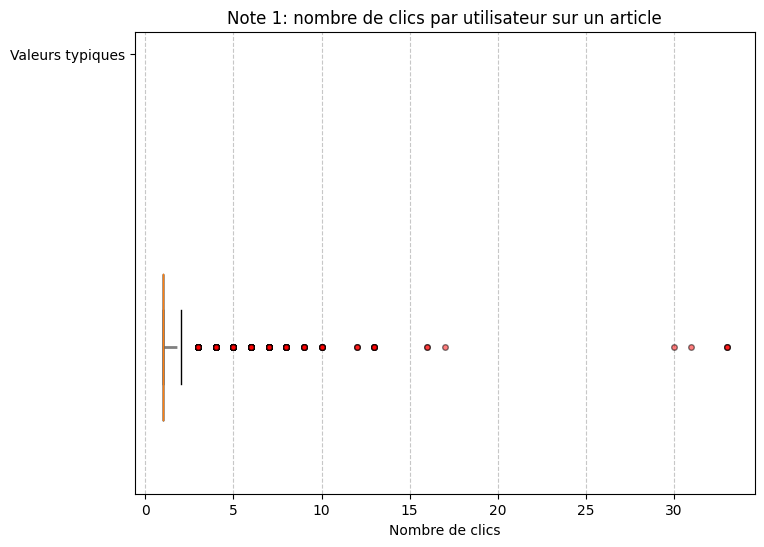

In [11]:
visualize_histogram(rates["clics_by_ua"], "Note 1: nombre de clics par utilisateur sur un article", "Nombre de clics", 'data/figs/rate_1.png')

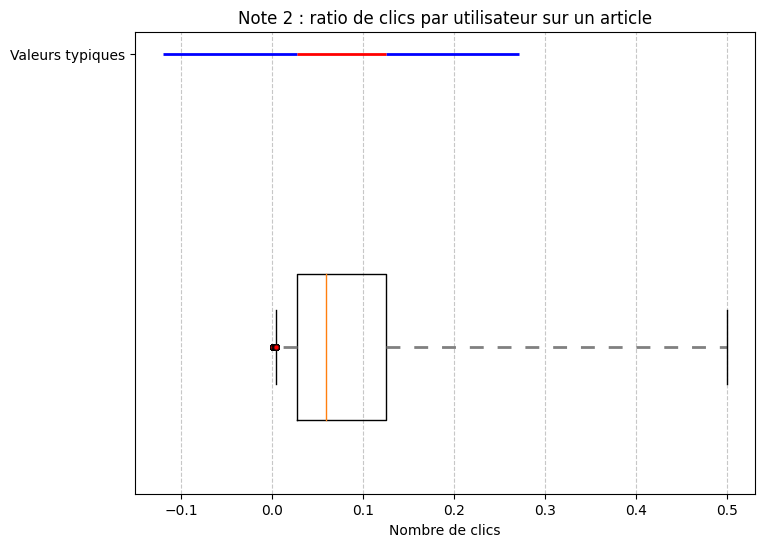

In [12]:
visualize_histogram(rates["user_clic_ratio"], "Note 2 : ratio de clics par utilisateur sur un article", "Nombre de clics", 'data/figs/rate_2.png')

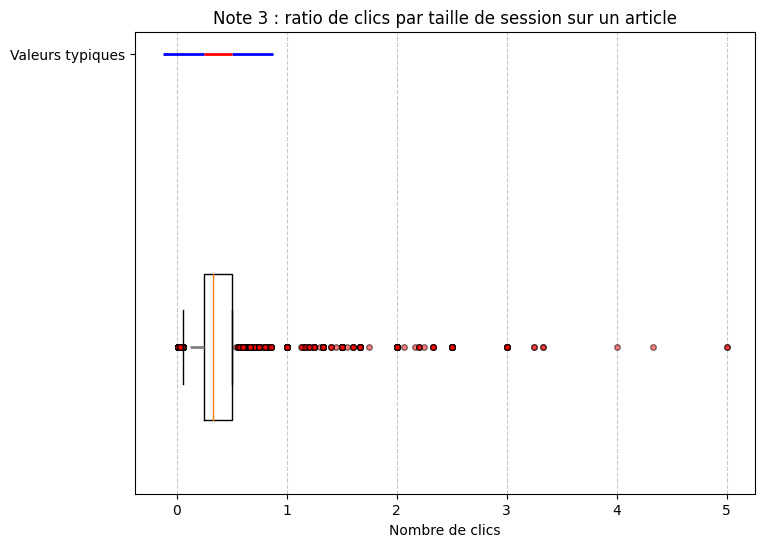

In [13]:
visualize_histogram( rates["clics_per_session"], "Note 3 : ratio de clics par taille de session sur un article", "Nombre de clics", 'data/figs/rate_3.png')

Le **ratio de clics par session** sur chaque article semble être la meilleure option car elle possède la plus grande variabilité de valeurs.
Il sera intéressant de tester également le nombre de **ratio de clics par utilisateur***.


#### Algorithme de filtrage collaboratif SVD

L'algorthime SVD  est utilisé pour le réaliser le filtrage collaboratif basé sur les comportements d'utilisateurs (user-based collaborative filtering). RAJOUTER DESCRIPTION SUR FACTO MATRICIELLE
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD 

- Les données reliant articles et utilisateurs sont fournies de façon **explicite** puisqu'il s'agit d'une note calculée;
- Les notes "clics_by_session" sont comprises entre 0 et 5. Le paramètre rating_scale de la classe Reader, utilisé dans la librairie surprise, est modifié de façon à spécifier la bonne échelle de notation des données dans la librairie;
- Les hyperparamètres **n_factors**, **n_epochs**, **lr_all** et **reg_all**  de l'algorithme SVD sont optimisés à l'aide d'une fonction gridsearch;
    -  n_factors correspond au nombre de facteurs latents (ou de dimensions cachées) utilisé pour décrire les utilisateurs et les articles dans le modèle;
    - n_epochs est le nombre d'itérations;
    - lr_all est le taux d'apprentissage pour tous les paramètres, qui est un paramètre qui décide de la quantité de réglage des paramètres à chaque itération;
    - reg_all est le terme de régularisation pour tous les paramètres, qui est un terme de pénalité ajouté pour éviter le surapprentissage. 
- Les métriques RMSE et MAE sont utilisés pour l'évaluation. Les valeurs des notes prédites et réelles sont également visualisées pour quelques paires article-utilisateur choisies.


<u> Approche item-based vs user-based</u>

EXPLIQUER ITEM VS USER 
Si le nombre d'utilisateurs est plus large que le nombre d'articles, l'approche item-based est plus rapide et plus stable. La note moyenne reçue par un article ne change pas aussi rapidement que la note moyenne donnée par un utilisateur à différents articles. Cette approche fonctionne également mieux lorsque la matrice de notes est clairsemée.

Dans notre cas le nombre d'utilisateurs est légèrement inférieur au nombre d'articles (lus), le taux de remplissage de la matrice est de 0.02 %.

La matrice étant quasiment vide, une technique de réduction de dimension comme une méthode de factorisation est utilisée pour améliorer les performances de l'algorithme de filtrage.


In [14]:
print(f"Nombre d'utilisateurs : {user_article['user_id'].nunique()}")
print(f"Nombre d'articles lus : {user_article['click_article_id'].nunique()}")
print(f"Nombre total d'articles : {articles_metadata['article_id'].nunique()}")
print(f"Nombre de paires utilisateur-article : {user_article.shape[0]}")
print(f"Taux de remplissage de la matrice user-article : {np.round(100*user_article.shape[0]/(user_article['user_id'].nunique()*user_article['click_article_id'].nunique()),2)} %")
print(f"Taille de la matrice : {np.round((1E-9)*(user_article['user_id'].nunique()*articles_metadata['article_id'].nunique()),2)} milliards")

Nombre d'utilisateurs : 322897
Nombre d'articles lus : 46033
Nombre total d'articles : 364047
Nombre de paires utilisateur-article : 2950710
Taux de remplissage de la matrice user-article : 0.02 %
Taille de la matrice : 117.55 milliards


In [19]:
# Data prepation for surprise
userId = 'user_id'
articleId = 'click_article_id'
# rating = 'user_clic_ratio' # Note 2
rating = 'clics_per_session' # Note 3
pred_rating = 'pred_' + rating 
data = rates

# Format data for surprise
# reader = Reader(rating_scale=(0,0.5)) # Note 2
reader = Reader(rating_scale=(0,5)) # Note 3

data = Dataset.load_from_df(data[[userId, articleId, rating]], reader)

# Choose training type
# training_type = 'simple' 
training_type = 'grid_search'


if training_type == 'simple':
    # Split data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.25, random_state=random_state)
    # trainset = data.build_full_trainset() # to use all data for training
     
    # Train the model
    SVD_model = SVD(n_factors=100, n_epochs=20, random_state=random_state)  
    cross_validate(SVD_model, data, measures=["RMSE", "MAE"], cv=3, verbose=True) # Run 5-fold cross-validation and print results
    # SVD_model.fit(trainset, verbose=True, n_jobs=-1)

    # Predict accuracy
    predictions = SVD_model.test(testset)  
    print('Basic model accuracy :')
    print(f"(rmse) : {accuracy.rmse(predictions)}")
    print(f"(mae): {accuracy.mae(predictions)}")
    print(f"(fcp): {accuracy.fcp(predictions)}")
    print(f"(mse): {accuracy.mae(predictions)}")


elif training_type == "grid_search":
    # grid search parameters
    param_grid = {'n_factors': [50, 100, 140], 'n_epochs': [10, 20, 50], 'lr_all':[0.002, 0.005, 0.007], 'reg_all':[0.01, 0.02, 0.03]} 

    # Train the model
    gs = GridSearchCV(SVD, param_grid, measures=["RMSE", "MAE"], cv=3, n_jobs=-1) # add  to use all cores
    gs.fit(data)

    # best RMSE score and parameters
    print('(Gridsearch-)Optimized model accuracy :')
    print(f"Best RMSE score : {gs.best_score['rmse']}")
    print(f"Best MAE score : {gs.best_score['mae']}")
    print(f"Best hyperparameters (rmse): {gs.best_params['rmse']}")
    print(f"Best hyperparameters (mae) : {gs.best_params['mae']}")
    print(f"Best model (rmse) : {gs.best_estimator['rmse']}")
    print(f"Best model (mae) : {gs.best_estimator['mae']}")

    # Train the best model
    SVD_model = gs.best_estimator['rmse']
    trainset = data.build_full_trainset() # to use all data for training
    SVD_model.fit(trainset)#, verbose=True, n_jobs=-1)

# Get predicted rates for each user-article pair already rated
rates[pred_rating] = rates.apply(lambda x: SVD_model.predict(x['user_id'], x['click_article_id']).est, axis=1) 

(Gridsearch-)Optimized model accuracy :
Best RMSE score : 0.11940757752031621
Best MAE score : 0.09542593981974579
Best hyperparameters (rmse): {'n_factors': 50, 'n_epochs': 50, 'lr_all': 0.007, 'reg_all': 0.03}
Best hyperparameters (mae) : {'n_factors': 50, 'n_epochs': 50, 'lr_all': 0.007, 'reg_all': 0.02}
Best model (rmse) : <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001DDE3A84550>
Best model (mae) : <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001DEA6E9A5F0>


KeyError: 'RMSE'

In [20]:
SVD_model = gs.best_estimator['rmse']
trainset = data.build_full_trainset() # to use all data for training
SVD_model.fit(trainset)#, verbose=True, n_jobs=-1)

In [21]:
rates[pred_rating] = rates.apply(lambda x: SVD_model.predict(x['user_id'], x['click_article_id']).est, axis=1) 

##### Métrique d'évaluation

Plusieurs métriques sont utilisées pour évaluer les prédictions. Ces évaluations sont réalisées sur un jeu de test contenant donc des paires article-utilisateur avec déjà une note réelle.
- Erreur RMSE (Root Mean Square Error): moyenne quadratique des erreurs des prediction
- Mean Absolute Error (MAE) : moyenne des valeurs absolues des erreurs

##### Visualisation des prédictions

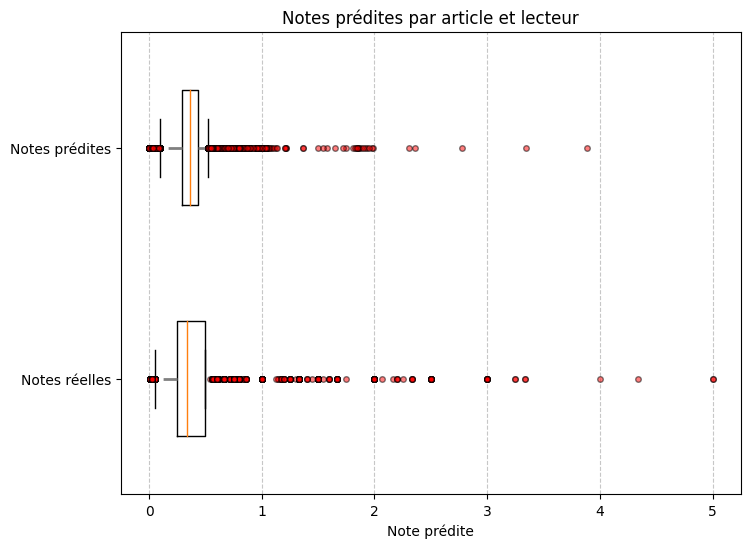

In [22]:
# Plot Boxplots for predicted rates and real rates
fig = plt.figure(figsize=figsize)

# Real rates
bp = plt.boxplot(rates[rating], vert=False, widths=0.5, positions=[0], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

# Predicted rates
bp = plt.boxplot(rates[pred_rating], vert=False, widths=0.5, positions=[1], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

# Predicted rates fullset
# bp = plt.boxplot(rates[pred_rating +'_fullset'], vert=False, widths=0.5, positions=[2], whis=[1,99])
# plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
# plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

plt.yticks([0, 1], ["Notes réelles", "Notes prédites"])
#plt.yticks([0, 1, 2], ["Notes réelles", "Notes prédites - Modèle de base", "Notes prédites - Modèle optimisé"])


plt.title("Notes prédites par article et lecteur") 
plt.xlabel("Note prédite")

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()
fig.savefig('data/figs/real_vs_pred_rates.png', dpi=300, bbox_inches='tight')

In [23]:
# Side by side comparison of real rates and predicted rates by user  
@interact(
    idx=widgets.IntSlider(min=min(rates['user_id'].unique()), max=max(rates['user_id'].unique()),
                          step=1, value=57288,#149963,
                          description="User Id :"))   


def show_side_by_side(idx):
    width = 0.35  # width of the bars
    n_bars = len(rates[rates['user_id']==idx])  # number of bars to plot
    ind = np.arange(n_bars)  # indices of the bars
    
    fig, ax = plt.subplots()

    # bars with real rates
    rects1 = ax.bar(ind, rates[rates['user_id']==idx][rating], width, color='r')

    # bars with predicted rates
    rects2 = ax.bar(ind + width, rates[rates['user_id']==idx][pred_rating], width, color='y')

    # bars with predicted rates fullset
    # rects3 = ax.bar(ind + width*2, rates[rates['user_id']==idx][pred_rating +'_fullset'], width, color='g')

    # legend and labels
    ax.set_xlabel('Observations')
    ax.set_ylabel('Valeurs')
    ax.legend((rects1[0], rects2[0]), ('Réelles', 'Prédites'))# , 'Prédites fullset')) #, rects3[0],
    ax.set_title('Comparaison des notes réelles et prédites pour les articles lus par un utilisateur')

    plt.show()


interactive(children=(IntSlider(value=57288, description='User Id :', max=322896), Output()), _dom_classes=('w…

In [24]:
# Side by side comparison of real rates and predicted rates for a chosen number of samples
@interact(n_bars=widgets.IntSlider(min=0, max=100,
                          step=1, value=10,
                          description="Nombre d'échantillons :"))   
def show_side_by_side(n_bars):
    width = 0.35  # width of the bars
    
    ind = np.arange(len(rates[rating]))  # indices of the bars
    selected_bars = np.random.choice(ind, n_bars)
    
    fig, ax = plt.subplots()

    # bars with real rates
    rects1 = ax.bar(np.arange(n_bars), rates[rating][selected_bars], width, color='r')

    # bars with predicted rates
    rects2 = ax.bar(np.arange(n_bars) + width, rates[pred_rating][selected_bars], width, color='y')

    # legend and labels
    ax.set_xlabel('Observations')
    ax.set_ylabel('Valeurs')
    ax.legend((rects1[0], rects2[0]), ('Réelles', 'Prédites'))
    ax.set_title(f"Comparaison des notes réelles et prédites pour un échantillon de {n_bars} paires article/lecteur")

    plt.show()


interactive(children=(IntSlider(value=10, description="Nombre d'échantillons :"), Output()), _dom_classes=('wi…

##### Recommandations

In [25]:
# Recommendation tool for collaborative filtering
@interact(
    idx=widgets.IntSlider(min=0, max=len(clicks['user_id'].unique()),
                          step=1, value=57288,
                          description="User Id :"))   
def show_data(idx):

    # 0. Get random user_id
    user_id = idx
    print('SELECTED USER : READ ARTICLES')
    print(f"User id : {user_id}")
    display(articles_metadata[articles_metadata['article_id'].isin(
        user_article[user_article['user_id']==idx]['click_article_id'].values)].drop(columns=['created_at_ts','publisher_id']))

    # 1. Predit rates for all the articles for this user_id and get the top 5 most rated articles
    top_recos, recos = get_best_rated_reco(user_id, articles_metadata, rates, SVD_model)
    print('--')    
    print(f"RECOMMENDED ARTICLES : {top_recos}")
    display(recos[recos['article_id'].isin(top_recos)].drop(columns=['predicted_rate','publisher_id']))

interactive(children=(IntSlider(value=57288, description='User Id :', max=322897), Output()), _dom_classes=('w…

##### Sauvegarde du modèle final

In [26]:
#### Sauvegarde du modèle

with open('model.pkl', 'wb') as f:
    pickle.dump(SVD_model, f)

## Synthèse des modèles de recommandation


### 4. Application Serverless

Le principe du Serverless est de pouvoir concevoir des applications sans avoir à penser à la gestion parfois fastidieuse des servers physiques, notamment:
- la configuration du framework Web
- le routage et la définition des requêtes

Le service le plus associé à la fonction Serverless est le service **Azure FaaS dit Azure Fonctions** (Function as a Service) :
- son fonctionnement se veut aussi simple qu'un fichier avec une seule méthode, la fonction Azure;
- cette méthode est appelée avec des déclencheurs ("trigger").

Il existe trois principes de Serverless :
- Pay as you go
- Event driven 
- Stateless : pour les fonctions de courte durée (5-10 min)

Le serverless est paticulièrement pratique pour les processus où la demande est faible ou chaotique, ainsi que pour ceux déclenché par des évènements  
